Titanic spaceship prediction, with the target variable being Transported (TRUE or FALSE)

In [5]:
# Importing the relevant modules
# General imports:-
from math import floor;
import numpy as np;
import pandas as pd;
from scipy.stats import iqr, mode;
from termcolor import colored;
from warnings import filterwarnings;
from gc import collect;
from tqdm.notebook import tqdm;

import seaborn as sns;
import matplotlib.pyplot as plt;
%matplotlib inline

# Sklearn and model imports:-
from sklearn.pipeline import Pipeline;
from sklearn.preprocessing import FunctionTransformer, LabelEncoder, StandardScaler;
from sklearn_pandas import DataFrameMapper, gen_features;  #conda install -c conda-forge sklearn-pandas
from sklearn.model_selection import GridSearchCV;

from lightgbm import LGBMClassifier;
from xgboost import XGBClassifier;
from catboost import CatBoostClassifier;   # conda install -c conda-forge catboost
from sklearn.metrics import auc, roc_auc_score;

# Spaceship Titanic Classification:-

In [10]:
# Importing relevant data:-
xytrain = pd.read_csv('train.csv'); # '../input/spaceship-titanic/train.csv'
xtest = pd.read_csv('test.csv');# '../input/spaceship-titanic/test.csv'
sub_fl = pd.read_csv('sample_submission.csv');# '../input/spaceship-titanic/sample_submission.csv'

# Visualizing the data:-
print(colored(f"\nTrain data:-\n", color = 'blue', attrs= ['bold', 'dark']));
display(xytrain.head(5));
print(colored(f"\nTest data:-\n", color = 'blue', attrs= ['bold', 'dark']));
display(xtest.head(5));
print(colored(f"\nSample Submission:-\n", color = 'blue', attrs= ['bold', 'dark']));
display(sub_fl.head(5));

Ftre_Lst = list(xytrain.drop('Transported', axis=1).columns);
Target = 'Transported';

print(colored(f"\nModel Features:-\n", color = 'blue', attrs= ['bold', 'dark']));
print(colored(f"{Ftre_Lst}", color = 'blue'));


Train data:-



,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True



Test data:-



,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name
0,0013_01,Earth,True,G/3/S,TRAPPIST-1e,27.0,False,0.0,0.0,0.0,0.0,0.0,Nelly Carsoning
1,0018_01,Earth,False,F/4/S,TRAPPIST-1e,19.0,False,0.0,9.0,0.0,2823.0,0.0,Lerome Peckers
2,0019_01,Europa,True,C/0/S,55 Cancri e,31.0,False,0.0,0.0,0.0,0.0,0.0,Sabih Unhearfus
3,0021_01,Europa,False,C/1/S,TRAPPIST-1e,38.0,False,0.0,6652.0,0.0,181.0,585.0,Meratz Caltilter
4,0023_01,Earth,False,F/5/S,TRAPPIST-1e,20.0,False,10.0,0.0,635.0,0.0,0.0,Brence Harperez



Sample Submission:-



,PassengerId,Transported
0,0013_01,False
1,0018_01,False
2,0019_01,False
3,0021_01,False
4,0023_01,False



Model Features:-

['PassengerId', 'HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'Age', 'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'Name']


# 1. Data visualization and pre-processing:-

In this section, we develop data visualizations and a strategy to fill nulls across the columns in the train-test sets

In [11]:
# Train-test information and description:-
print(colored(f"\nTrain set info\n", color=  'blue', attrs= ['bold', 'dark']));
display(xytrain.info());

print(colored(f"\nTest set info\n", color=  'blue', attrs= ['bold', 'dark']));
display(xtest.info());

print(colored(f"\nTrain set description\n", color=  'blue', attrs= ['bold', 'dark']));
display(xytrain.describe().transpose().style.format('{:,.2f}'));

print(colored(f"\nTest set description\n", color=  'blue', attrs= ['bold', 'dark']));
display(xtest.describe().transpose().style.format('{:,.2f}'));


Train set info

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


None


Test set info

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4277 entries, 0 to 4276
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   4277 non-null   object 
 1   HomePlanet    4190 non-null   object 
 2   CryoSleep     4184 non-null   object 
 3   Cabin         4177 non-null   object 
 4   Destination   4185 non-null   object 
 5   Age           4186 non-null   float64
 6   VIP           4184 non-null   object 
 7   RoomService   4195 non-null   float64
 8   FoodCourt     4171 non-null   float64
 9   ShoppingMall  4179 non-null   float64
 10  Spa           4176 non-null   float64
 11  VRDeck        4197 non-null   float64
 12  Name          4183 non-null   object 
dtypes: float64(6), object(7)
memory usage: 434.5+ KB


None


Train set description



,count,mean,std,min,25%,50%,75%,max
Age,"8,514.00",28.83,14.49,0.00,19.00,27.00,38.00,79.00
RoomService,"8,512.00",224.69,666.72,0.00,0.00,0.00,47.00,"14,327.00"
FoodCourt,"8,510.00",458.08,"1,611.49",0.00,0.00,0.00,76.00,"29,813.00"
ShoppingMall,"8,485.00",173.73,604.70,0.00,0.00,0.00,27.00,"23,492.00"
Spa,"8,510.00",311.14,"1,136.71",0.00,0.00,0.00,59.00,"22,408.00"
VRDeck,"8,505.00",304.85,"1,145.72",0.00,0.00,0.00,46.00,"24,133.00"



Test set description



,count,mean,std,min,25%,50%,75%,max
Age,"4,186.00",28.66,14.18,0.00,19.00,26.00,37.00,79.00
RoomService,"4,195.00",219.27,607.01,0.00,0.00,0.00,53.00,"11,567.00"
FoodCourt,"4,171.00",439.48,"1,527.66",0.00,0.00,0.00,78.00,"25,273.00"
ShoppingMall,"4,179.00",177.30,560.82,0.00,0.00,0.00,33.00,"8,292.00"
Spa,"4,176.00",303.05,"1,117.19",0.00,0.00,0.00,50.00,"19,844.00"
VRDeck,"4,197.00",310.71,"1,246.99",0.00,0.00,0.00,36.00,"22,272.00"


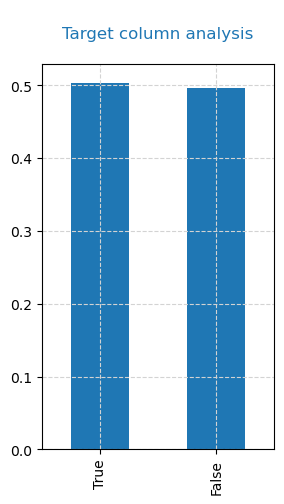

In [12]:
# Target column balance plot:-
fig, ax = plt.subplots(1,1, figsize= (3,5));
xytrain.Transported.value_counts(normalize= True).plot.bar(ax= ax, color = 'tab:blue');
ax.set_title(f"\nTarget column analysis\n", color = 'tab:blue', fontsize= 12);
ax.grid(visible= True, linestyle= '--', which = 'both', color = 'lightgrey');
plt.show();

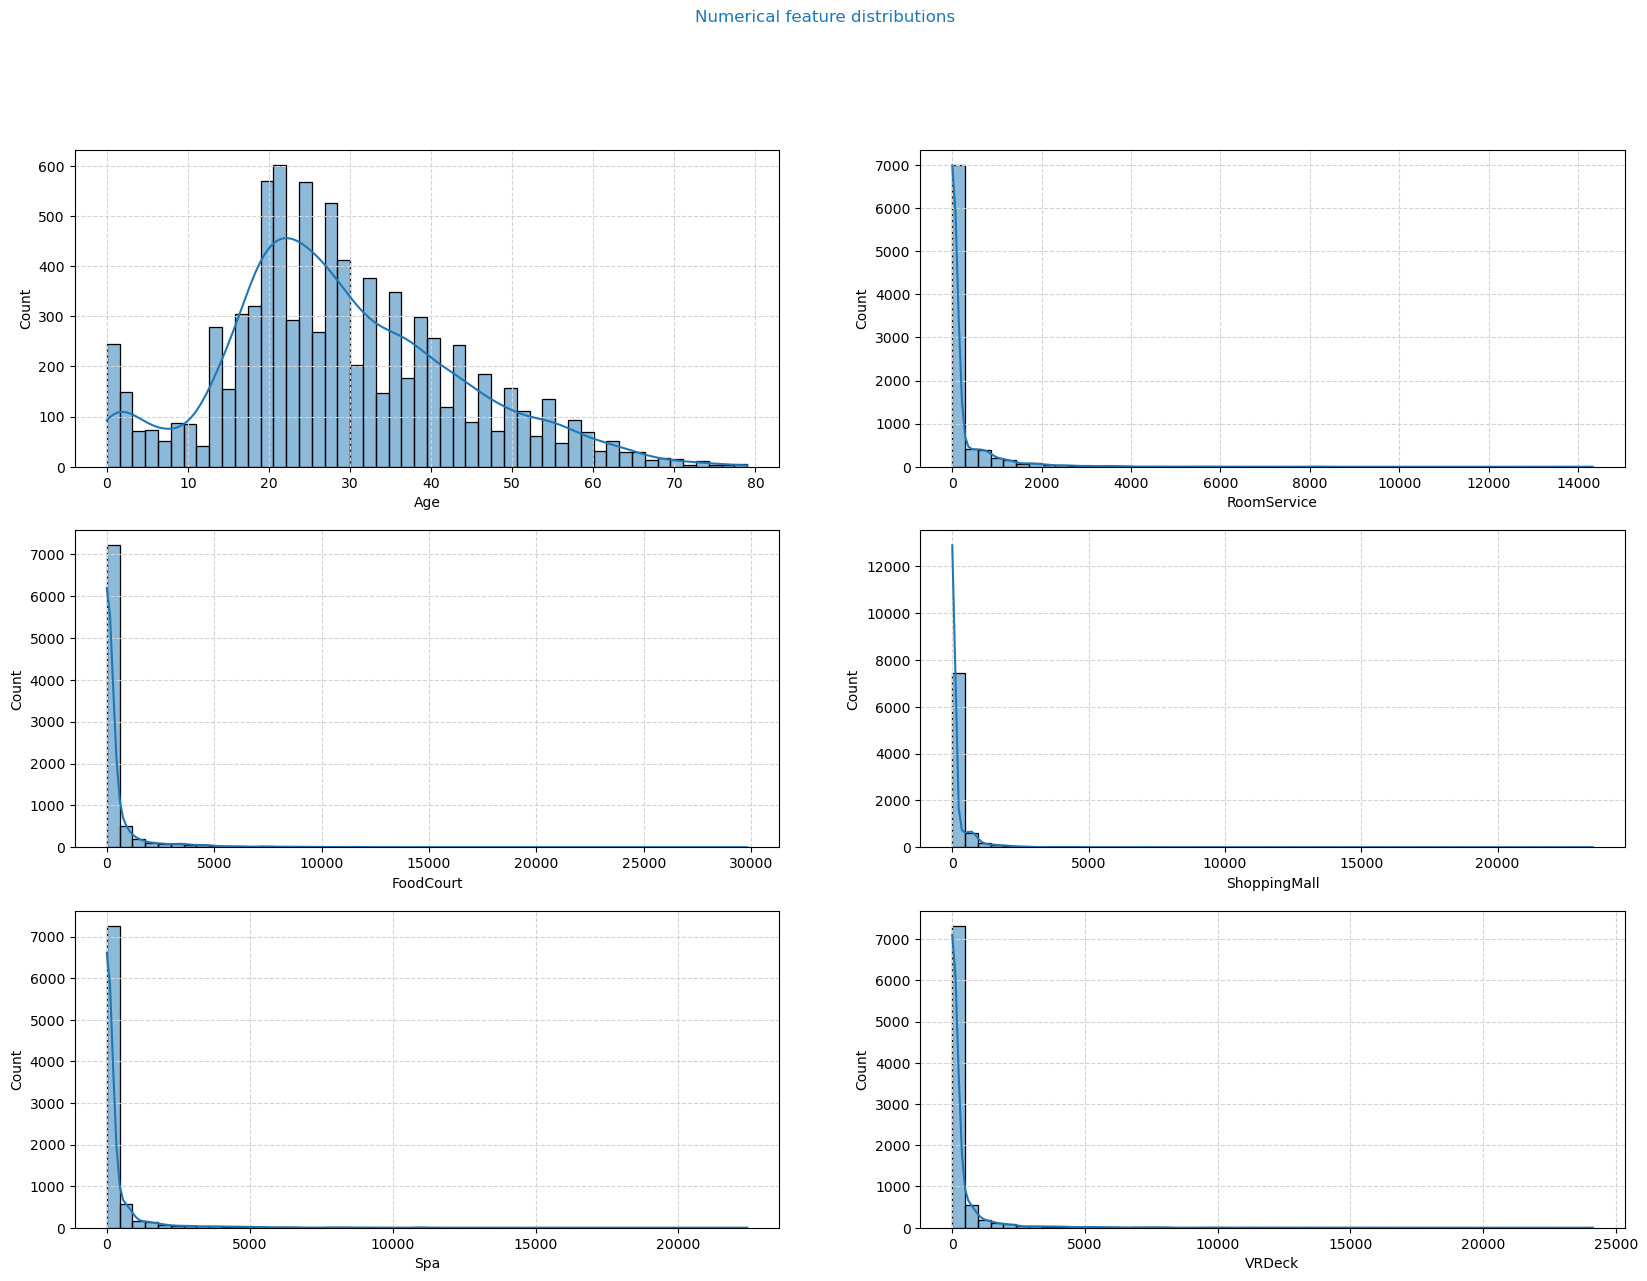

In [13]:
# Analyzing numerical feature distributions:-
Num_Ftre_Lst = list(xytrain.select_dtypes(include= np.number).columns);

fig, ax = plt.subplots(3,2, figsize=(20,14));
for i, col in enumerate(Num_Ftre_Lst):
    sns.histplot(x=xytrain[col], bins=50, kde= True, color = 'tab:blue', ax=ax[floor(i/2), i%2]);
    ax[floor(i/2), i%2].grid(visible= True, color= 'lightgrey', linestyle= '--', which= 'both');
plt.suptitle(f"Numerical feature distributions", color= 'tab:blue', fontsize=12);
plt.show();

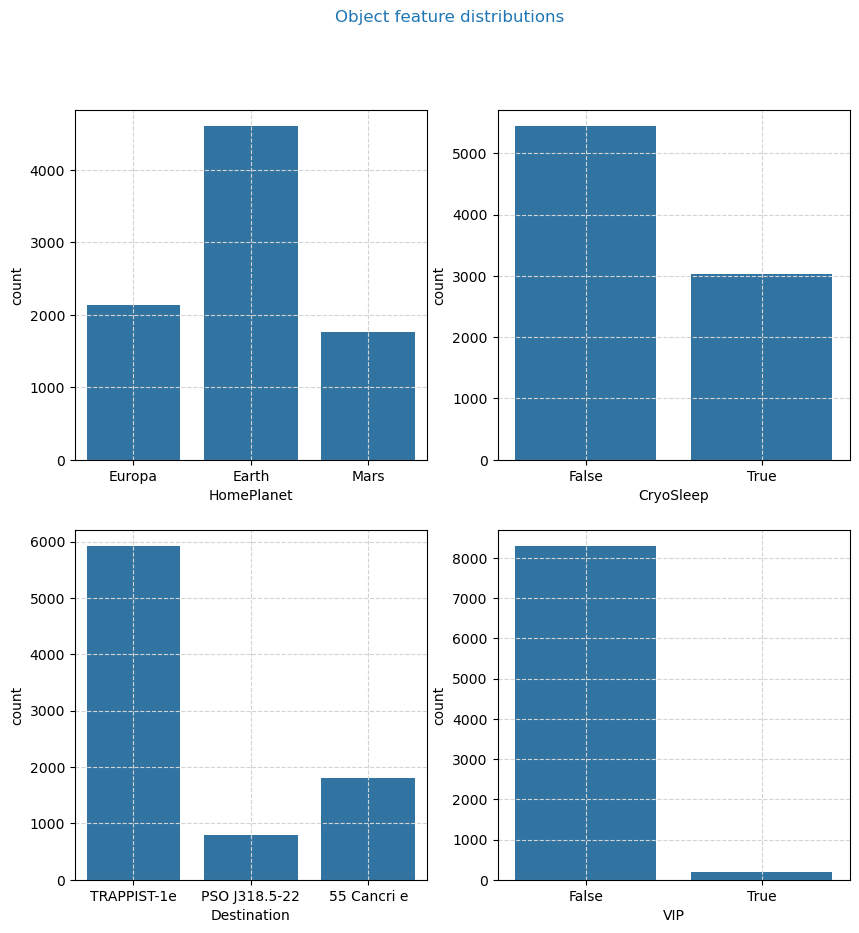

In [14]:
# Analyzing object feature distributions:-
fig, ax = plt.subplots(2,2, figsize=(10,10));
for i, col in enumerate(['HomePlanet', 'CryoSleep', 'Destination', 'VIP']):
    sns.countplot(x=xytrain[col], color = 'tab:blue', ax=ax[floor(i/2), i%2]);
    ax[floor(i/2), i%2].grid(visible= True, color= 'lightgrey', linestyle= '--', which= 'both');
plt.suptitle(f"Object feature distributions", color= 'tab:blue', fontsize=12);
plt.show();

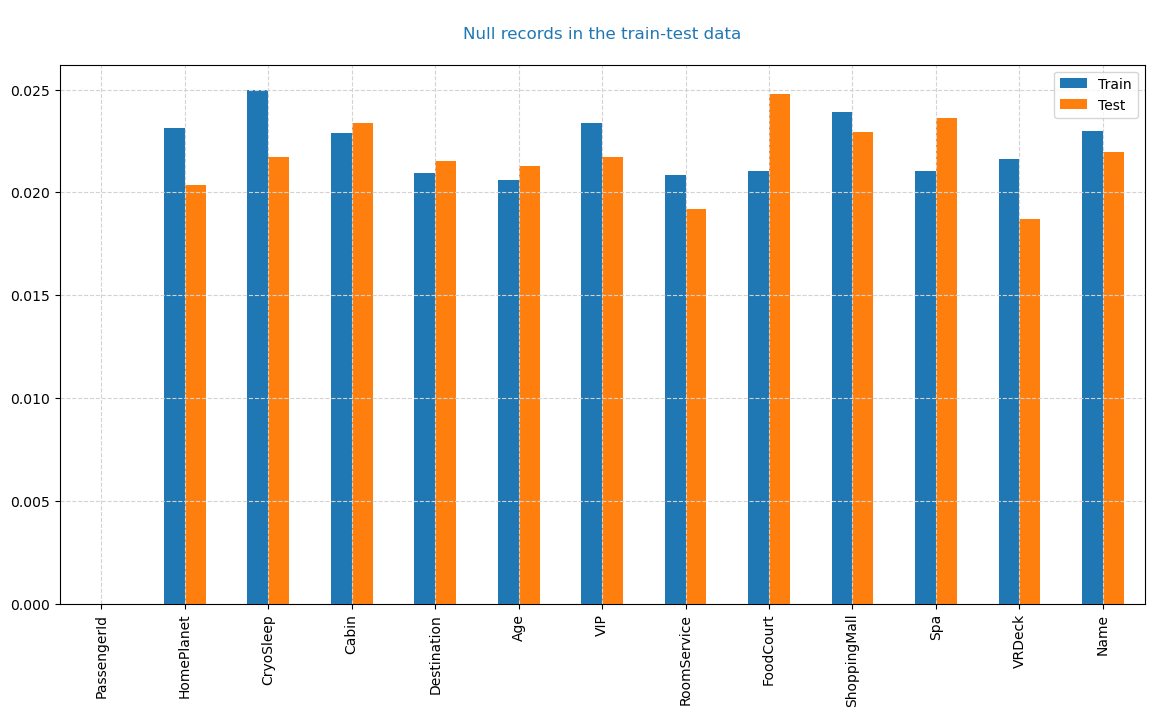


Null records in the train-test data



,Train,Test
HomePlanet,2.31%,2.03%
CryoSleep,2.50%,2.17%
Cabin,2.29%,2.34%
Destination,2.09%,2.15%
Age,2.06%,2.13%
VIP,2.34%,2.17%
RoomService,2.08%,1.92%
FoodCourt,2.11%,2.48%
ShoppingMall,2.39%,2.29%
Spa,2.11%,2.36%


In [15]:
# Null check:-
_ = pd.concat((xytrain[Ftre_Lst].isna().sum(axis=0)/ len(xytrain), 
               xtest.isna().sum(axis=0)/ len(xtest)), axis=1).\
rename({0:'Train', 1:'Test'}, axis=1);

fig, ax = plt.subplots(1,1, figsize= (14,7));
_.plot.bar(ax=ax);
ax.grid(visible= True, linestyle= '--', which = 'both', color = 'lightgrey');
ax.set_title("\nNull records in the train-test data\n", color = 'tab:blue', fontsize= 12);
plt.show();

print(colored(f"\nNull records in the train-test data\n", 
              color='blue', attrs= ['bold', 'dark']));
display(_.drop('PassengerId').style.format('{:.2%}').highlight_max(color= 'lightblue', axis=0).\
       highlight_min(color = 'lightyellow', axis=0));

In [16]:
# Analyzing categorical feature levels and associated target states:-
for col in xytrain.drop(['Name', 'PassengerId', 'Cabin'], axis=1).\
select_dtypes(exclude= np.number).columns:
    print(colored(f"\nAnalysis for {col}\n", color = 'blue', attrs= ['dark', 'bold']));
    display(xytrain.groupby(col,dropna=False).\
    agg(Nb_Records=pd.NamedAgg('Transported', np.size),
        Nb_Transported = pd.NamedAgg('Transported', np.sum)));


Analysis for HomePlanet



,Nb_Records,Nb_Transported
HomePlanet,,
Earth,4602,1951
Europa,2131,1404
Mars,1759,920
NaN,201,103



Analysis for CryoSleep



,Nb_Records,Nb_Transported
CryoSleep,,
False,5439,1789
True,3037,2483
NaN,217,106



Analysis for Destination



,Nb_Records,Nb_Transported
Destination,,
55 Cancri e,1800,1098
PSO J318.5-22,796,401
TRAPPIST-1e,5915,2787
NaN,182,92



Analysis for VIP



,Nb_Records,Nb_Transported
VIP,,
False,8291,4198
True,199,76
NaN,203,104



Analysis for Transported



,Nb_Records,Nb_Transported
Transported,,
False,4315,0
True,4378,4378


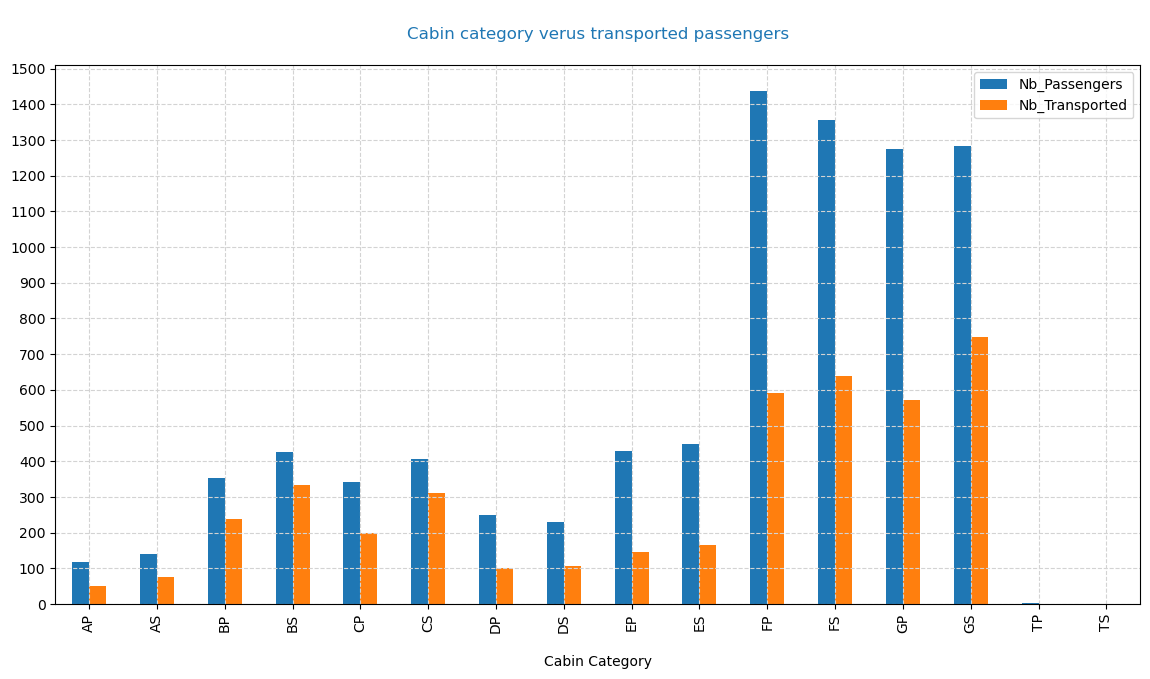

In [17]:
# Analyzing the cabin column further:-
_cabin_prf = xytrain.Cabin.str.split('/', expand= True).add_prefix('Cabin').join(xytrain.Transported);
_cabin_prf['CabinCtg'] = _cabin_prf['Cabin0']+_cabin_prf['Cabin2'];

fig, ax = plt.subplots(1,1, figsize= (14,7));
_cabin_prf.groupby('CabinCtg').agg(Nb_Passengers= pd.NamedAgg('Transported',np.size), 
                                   Nb_Transported= pd.NamedAgg('Transported',np.sum)
                                  ).plot.bar(ax= ax);
ax.set_title(f"\nCabin category verus transported passengers\n", color= 'tab:blue', fontsize= 12);
ax.grid(visible= True, linestyle= '--', which = 'both', color = 'lightgrey');
ax.set_yticks(range(0,1600,100), fontsize= 8);
ax.set_xlabel("\nCabin Category");
plt.show();

In [18]:
# Generating cross-tab between cabin category and destination:-
_ = _cabin_prf.join(xytrain.Destination).groupby(['Destination', 'CabinCtg']).\
agg({'Transported': [np.size, np.sum]}).reset_index().\
pivot(index= 'CabinCtg', columns= 'Destination');

_.columns = [j+'-'+k for i, j,k in _.columns.to_flat_index()];

print(colored(f"\nCross-tab between cabin category and destination\n", 
              color = 'blue', attrs= ['bold', 'dark']));
display(_.style.format(precision = 0));

del _;


Cross-tab between cabin category and destination



,size-55 Cancri e,size-PSO J318.5-22,size-TRAPPIST-1e,sum-55 Cancri e,sum-PSO J318.5-22,sum-TRAPPIST-1e
CabinCtg,,,,,,
AP,53,nan,62,24,nan,25
AS,55,2,80,34,2,40
BP,155,2,187,109,1,124
BS,178,1,239,145,1,181
CP,152,6,174,95,4,91
CS,165,7,231,125,6,177
DP,55,9,179,33,3,63
DS,58,8,159,36,3,65
EP,50,21,350,35,14,94


In [19]:
# Generating cross-tab between cabin category and embarkation:-
_ = _cabin_prf.join(xytrain.HomePlanet).groupby(['HomePlanet', 'CabinCtg']).\
agg({'Transported': [np.size, np.sum]}).reset_index().\
pivot(index= 'CabinCtg', columns= 'HomePlanet');

_.columns = [j+'-'+k for i, j,k in _.columns.to_flat_index()];

print(colored(f"\nCross-tab between cabin category and HomePlanet\n", 
              color = 'blue', attrs= ['bold', 'dark']));
display(_.style.format(precision = 0));

del _;


Cross-tab between cabin category and HomePlanet



,size-Earth,size-Europa,size-Mars,sum-Earth,sum-Europa,sum-Mars
CabinCtg,,,,,,
AP,nan,115,nan,nan,51,nan
AS,nan,137,nan,nan,74,nan
BP,nan,348,nan,nan,234,nan
BS,nan,418,nan,nan,328,nan
CP,nan,338,nan,nan,196,nan
CS,nan,396,nan,nan,301,nan
DP,nan,89,153,nan,56,42
DS,nan,97,129,nan,53,52
EP,199,62,158,76,38,28


In [20]:
# Generating cross-tab between cabin category and VIP status:-
_ = _cabin_prf.join(xytrain.VIP).groupby(['VIP', 'CabinCtg']).\
agg({'Transported': [np.size, np.sum]}).reset_index().\
pivot(index= 'CabinCtg', columns= 'VIP');
_.columns = [j+'-'+str(k) for i, j,k in _.columns.to_flat_index()];

print(colored(f"\nCross-tab between cabin category and VIP-status\n", 
              color = 'blue', attrs= ['bold', 'dark']));
display(_.style.highlight_max(axis=0, color = 'lightblue').\
        highlight_min(axis=0, color = 'lightyellow').\
        format('{:,.0f}'));

del _;


Cross-tab between cabin category and VIP-status



,size-False,size-True,sum-False,sum-True
CabinCtg,,,,
AP,101,15,48,2
AS,114,20,62,10
BP,324,24,222,11
BS,401,18,319,11
CP,312,21,182,10
CS,375,20,286,16
DP,228,18,97,2
DS,210,13,101,4
EP,413,5,141,2


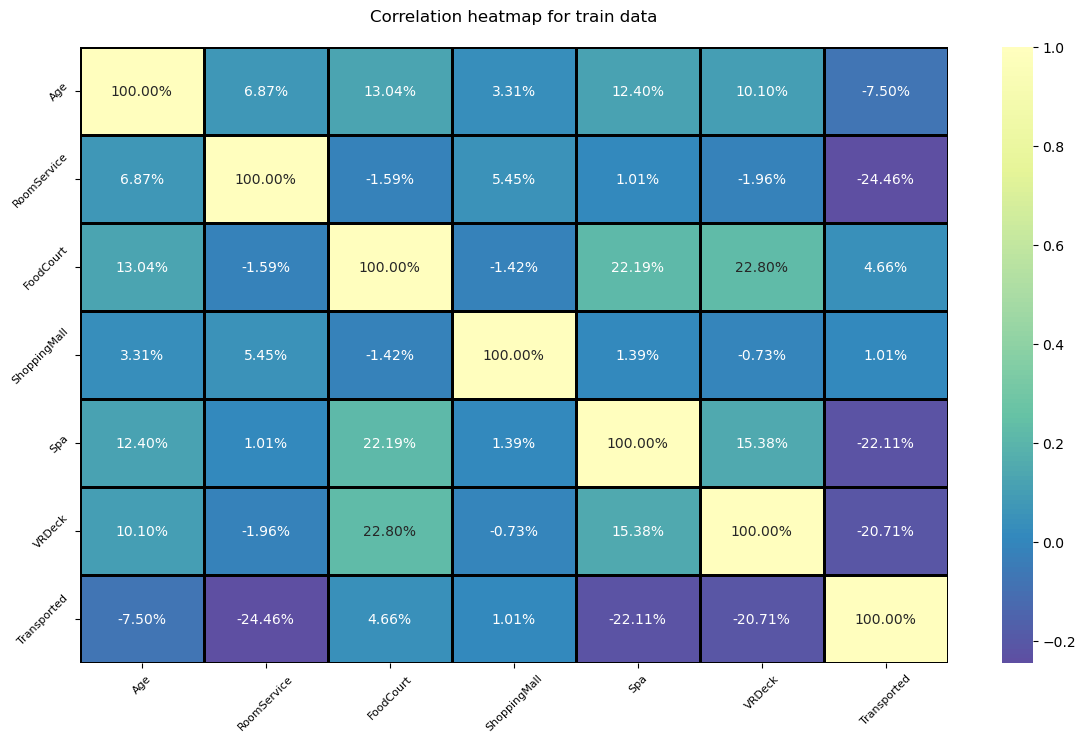

In [21]:
# Analyzing the correlation between the training features and the target:-
fig, ax = plt.subplots(1,1,figsize= (14,8));
sns.heatmap(data=xytrain.corr(), cmap = 'Spectral_r', ax=ax,linecolor= 'black', center=True,
            linewidth = 1.0, annot= True, fmt= '.2%');
ax.set_title(f"Correlation heatmap for train data\n", color = 'black', fontsize= 12);
plt.yticks(rotation= 45, fontsize= 8);
plt.xticks(rotation= 45, fontsize= 8);
plt.show();

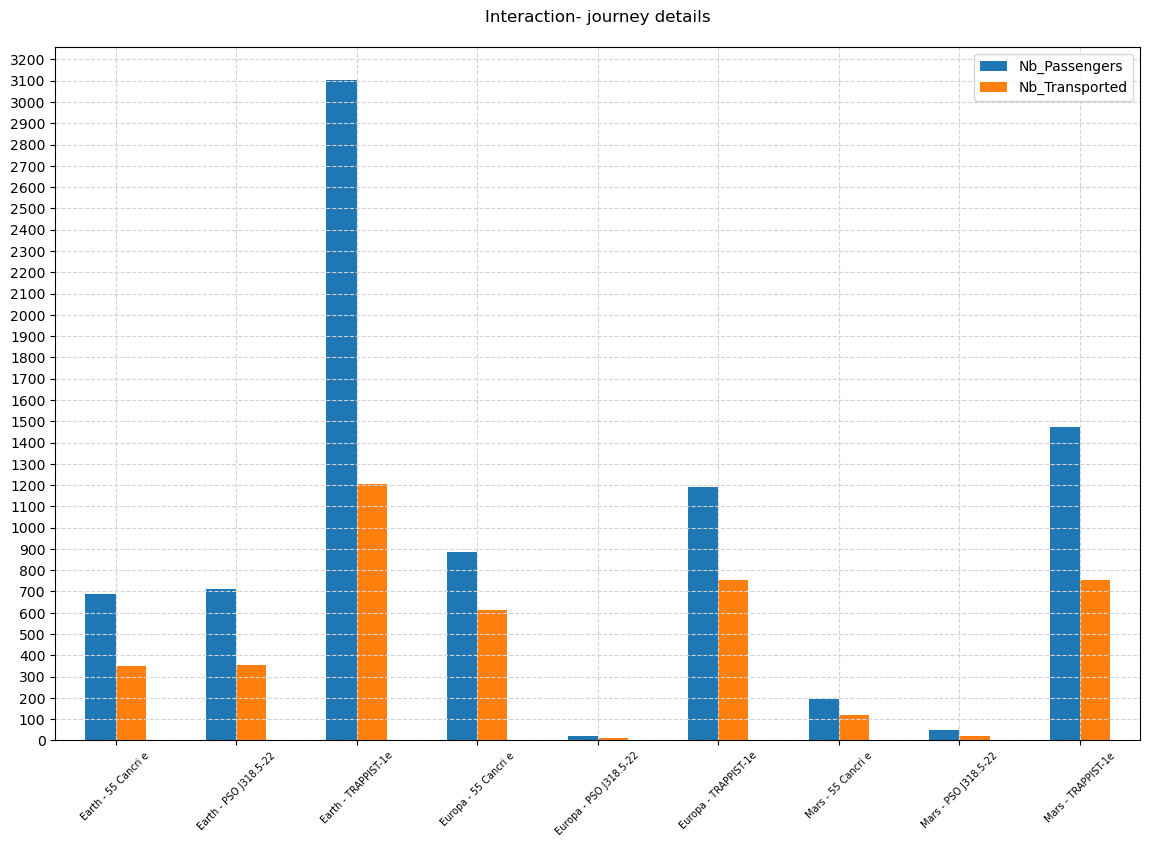


Interaction- journey details



,Nb_Passengers,Nb_Transported
Journey_Lbl,,
Earth - 55 Cancri e,690,348
Earth - PSO J318.5-22,712,355
Earth - TRAPPIST-1e,"3,101","1,207"
Europa - 55 Cancri e,886,611
Europa - PSO J318.5-22,19,14
Europa - TRAPPIST-1e,"1,189",755
Mars - 55 Cancri e,193,118
Mars - PSO J318.5-22,49,22
Mars - TRAPPIST-1e,"1,475",755


In [22]:
# Analyzing the HomePlanet and destination interaction feature:-

_ = pd.concat((xytrain['HomePlanet']+ ' - ' + xytrain['Destination'], xytrain.Transported), axis=1).\
rename({0:'Journey_Lbl'}, axis=1).groupby('Journey_Lbl').agg({'Transported': [np.size, np.sum]});
_.columns = ['Nb_Passengers', 'Nb_Transported'];

fig, ax = plt.subplots(1,1, figsize= (14,9));
_.plot.bar(ax =ax);
ax.set_title("Interaction- journey details\n", fontsize= 12, color = 'black');
ax.grid(visible= True, linestyle= '--', which = 'both', color = 'lightgrey');
ax.set_xlabel('');
ax.set_yticks(range(0,3300,100));
plt.xticks(rotation= 45, fontsize= 7);
plt.show();

del fig, ax;

print(colored(f"\nInteraction- journey details\n", color=  'blue', attrs= ['bold', 'dark']));
display(_.style.highlight_max(axis=0, color = 'lightblue').
        highlight_min(axis=0, color = 'lightyellow').
        format('{:,.0f}'));
del _;

In [23]:
# Analyzing customer spending by VIP-status and cryosleep:-
filterwarnings('ignore');
_ = xytrain[['CryoSleep','VIP', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']];
_['Total_Spend'] = _.select_dtypes(include= np.number).sum(axis=1);

print(colored(f"Cross-tab:- Total Spend versus Cryosleep and VIP status\n",
      color = 'blue', attrs= ['dark', 'bold']));
display(_.groupby(['CryoSleep', 'VIP'])['Total_Spend'].describe().\
        style.highlight_max(axis=0, color= 'lightblue').\
        format('{:,.2f}'));

# Analyzing transported passengers versus VIP-status and cryosleep:-
_xtab = _[['VIP','CryoSleep']].join(xytrain.Transported).\
groupby(['VIP','CryoSleep']).agg({'Transported': [np.size, np.sum]});
_xtab.columns = ['Nb_Passengers', 'Nb_Transported'];
_xtab['Rt_Transported'] = _xtab['Nb_Transported']/ _xtab['Nb_Passengers'];

print(colored(f"\nCross-tab:- Total transported passengers versus Cryosleep and VIP status\n",
      color = 'blue', attrs= ['dark', 'bold']));
display(_xtab.style.format({'Nb_Passengers': '{:,.0f}','Nb_Transported': '{:,.0f}',
                           'Rt_Transported': '{:.2%}'}));

del _xtab;

Cross-tab:- Total Spend versus Cryosleep and VIP status




Cross-tab:- Total transported passengers versus Cryosleep and VIP status



In [24]:
# Analyzing total spending and target distribution by age:-
_ = _[['Total_Spend', 'VIP', 'CryoSleep']].join(xytrain[['Age', 'Transported']]);
_['Lifestage'] = np.select([_.Age < 13.0, _.Age<18.0], ['1.Child', '2.Teen'], '3.Adult');

print(colored(f"Cross-tab:- Total transported passengers versus Cryosleep,VIP status and Lifestage\n",
      color = 'blue', attrs= ['dark', 'bold']));
display(
_.groupby(['Lifestage','VIP','CryoSleep']).\
agg({'Transported': [np.size, np.sum],'Total_Spend': [np.mean, np.median]}).\
style.format('{:,.0f}').highlight_max(axis=1, color= 'lightblue').\
highlight_min(axis=1, color= 'lightyellow')
);

Cross-tab:- Total transported passengers versus Cryosleep,VIP status and Lifestage



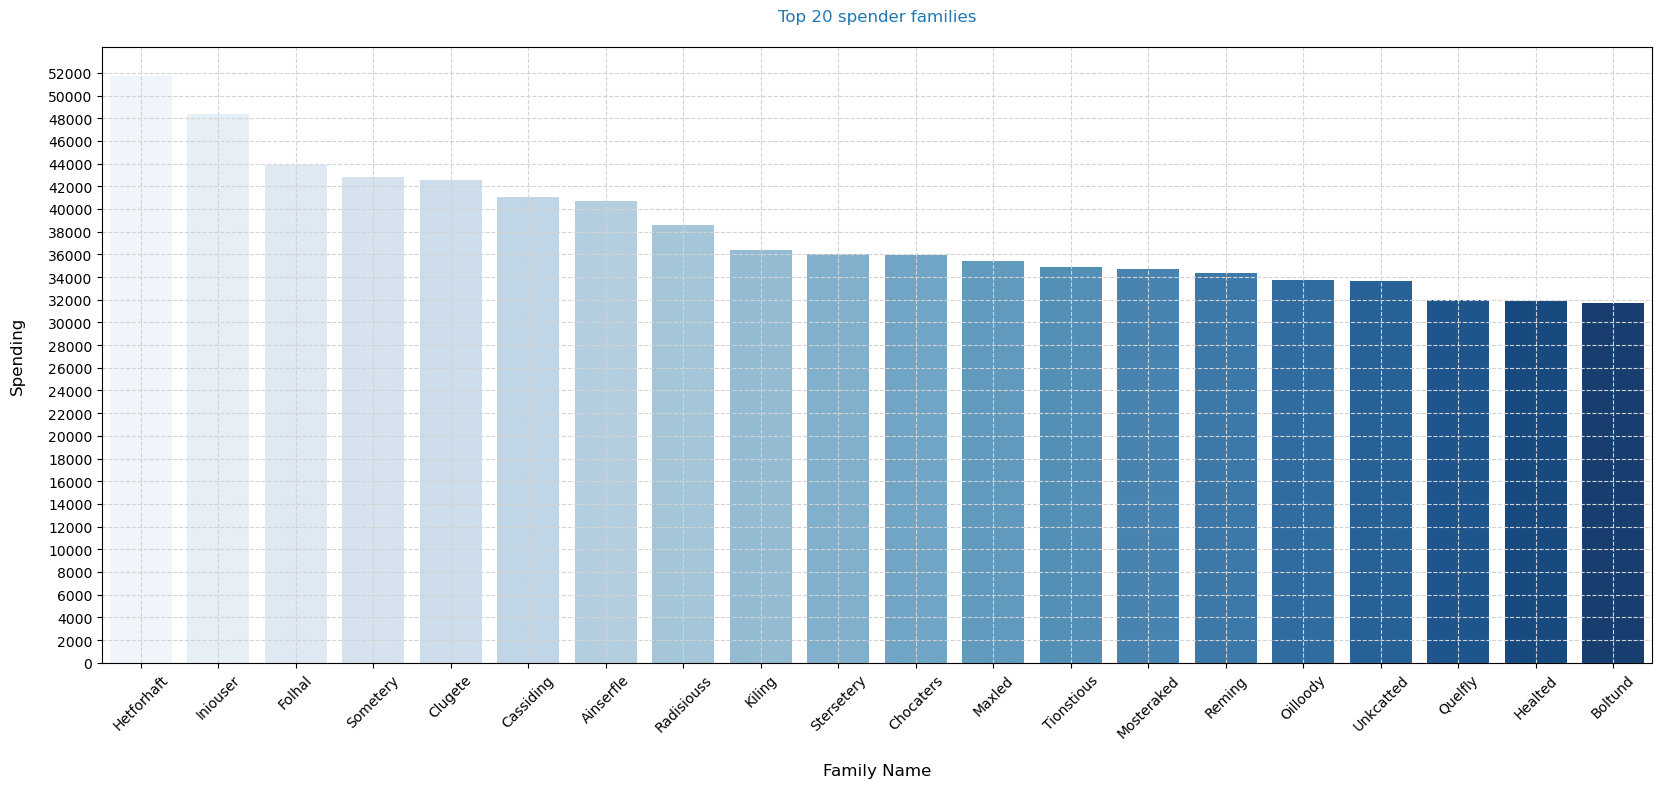

In [25]:
# Analyzing Name and Passenger ID to elicit filial relations:-
_ = pd.concat((xytrain['PassengerId'].str.split('_', expand= True).add_prefix('ID'),
               xytrain['Name'].str.split(' ', expand= True).\
               rename({0:'FirstName', 1:'LastName'}, axis=1),
              _[['Total_Spend']],
              xytrain[['CryoSleep', 'Transported', 'VIP']]
              ),
              axis=1);
_['CryoSleep'] = np.where(_.CryoSleep == True, 1,0);

# Pooling spending details and passengers per family name:-
_family_dtl = \
_.groupby(['VIP','LastName']).\
agg(Total_Spend = pd.NamedAgg('Total_Spend',np.sum),
    Nb_Passengers = pd.NamedAgg('Transported', np.size),
    Nb_Transported = pd.NamedAgg('Transported', np.sum),
    Nb_CryoSleep = pd.NamedAgg('CryoSleep', np.sum)
   ).\
reset_index().sort_values('Total_Spend', ascending= False);

_family_dtl['Rt_Transport'] = _family_dtl['Nb_Transported']/ _family_dtl['Nb_Passengers'];

# Plotting the top 20 spender families:-
fig, ax= plt.subplots(1,1, figsize= (20,8));
sns.barplot(data= _family_dtl.head(20),y= 'Total_Spend', x= 'LastName', 
            palette= 'Blues', ax=ax);
ax.set_title("Top 20 spender families\n", color= 'tab:blue', fontsize=12);
ax.grid(visible= True, which= 'both', linestyle= '--', color= 'lightgrey');
ax.set_yticks(range(0,53000,2000));
ax.set_xlabel(f"\nFamily Name\n", fontsize=12);
ax.set_ylabel(f"Spending\n", fontsize=12);
plt.xticks(rotation=45);
plt.show();

## Key notes and inferences:-

1. People in cryosleep did not spend any money throughout the trip
2. Transportation rate for cryosleep > others
3. VIP passengers also have higher transportation rate than others
4. Children have a higher propensity for cryosleep and transportation
5. Children under 12 years of age did not spend any money at all (could be a policy)


# 2. Data Transformation Pipeline:-

In this section, we develop a pipeline that elicits the data transformation process and returns the associated model train-test sets. Custom classes and functions are used to develop the pipeline.

This is divided into 4 functions as below-
1. Add features- create new columns for name, cabinID components and treat nulls in float columns for amenities
2. Treat nulls in age and cryosleep columns based on family name and spending details
3. Create journey column based on null treated home planet and destination, based on family name
4. Treat nulls in VIP and cabin columns based on family names

The pipeline is then developed using FunctionTransformer as all of these functions are stateless

In [26]:
def AddFeatures(X: pd.DataFrame):
    "This function adds the name split, total spending features and treats nulls in amenities";
    
    df = pd.concat((X[Ftre_Lst].drop(['Name', 'Cabin'],axis=1),
                X.Name.str.split(' ', expand= True).add_prefix('Name'),
                X.Cabin.str.split('/', expand= True).add_prefix('Cabin')), axis=1);

    df[['RoomService', 'FoodCourt','ShoppingMall','Spa','VRDeck']]=\
    df[['RoomService', 'FoodCourt','ShoppingMall','Spa','VRDeck']].fillna(0.0);
    df['TotalSpend'] = df['RoomService'] + df['FoodCourt'] + df['ShoppingMall'] + \
    df['Spa'] + df['VRDeck'];
    
    df['VIP'] = df['VIP']*1.0;
    df['VIP'] = df['VIP'].astype(np.float16);
    
    return df;

In [27]:
def TrtNullAgeCrSlp(df:pd.DataFrame):
    """
    This function fills nulls in age and cryosleep as below-
    Cryosleep:-
    1. For non-spenders, cryosleep=1 as cryosleep customers don't spend
    2. If age <=12 and cryosleep is null, then cryosleep= 1
    3. For spenders, cryosleep= 0
    
    Age:-
    1. For spenders/ non-cryosleep, median age > 12 for family is considered (child cannot spend)
    2. For all remaining nulls, overall median age is used
    
    Flag for Is_Child (Age <=12) is also created
    """;
    
    # 1. Filling nulls in cryosleep based on spending and age details:-
    df['CryoSleep'] = np.float16(df['CryoSleep']*1.0);
    df.loc[(df.CryoSleep.isna()==True) & (df.TotalSpend == 0.0), ['CryoSleep']] = 1.0;
    # Assuming child (age <=12) and null cryosleep = cryosleep
    df.loc[(df.CryoSleep.isna()==True) & (df.Age <=12), ['CryoSleep']] = 1.0;
    # Assuming no cryosleep for spenders:-
    df.loc[(df.CryoSleep.isna()==True) & (df['TotalSpend'] > 0.0), ['CryoSleep']] = 0.0;
    df['CryoSleep'] = df['CryoSleep'].astype(np.int8);
    
    # 2. Assuming average family age for spenders:-
    df = df.merge(df.loc[df.Age >12,['Name1', 'Age']].dropna().groupby('Name1').\
                  agg(_Age= pd.NamedAgg('Age', np.median)),
                  how= 'left', left_on= 'Name1', right_on='Name1', suffixes= ('',''));
    df.loc[(df.Age.isna()==True) & ((df.TotalSpend > 0.0) | (df.CryoSleep==0)), ['Age']] = df._Age;
    # Filling median age for remaining nulls:-
    df['Age'] = df['Age'].fillna(df.Age.median());
    
    # 3. Creating flag for child:-
    df['Is_Child'] = np.where(df.Age <= 12, 1,0);
    df['Is_Child'] = df['Is_Child'].astype(np.int8);
    
    df = df.drop(['_Age'], axis=1);  
    df['Age'] = df['Age'].astype(np.int8);
    return df;

In [28]:
def CreateJourney(df: pd.DataFrame):
    """
    This function treats nulls in HomePlanet and Destination and combines them to form Journey
    1. Home Planet:-
    a. Based on family name, home planet nulls are filled (all family members have same home planet)
    b. Remaining nulls are filled using the overall mode
    
    2. Destination:-
    a. Based on family name, mode of destination is created and filled up for nulls
    b. For all remaining nulls, overall mode is used
    
    3. Journey = HomePlanet - Destination is the interaction feature
    """;
    
    # 1. Fostering null treatment for HomePlanet based on last name and overall mode:-
    df = df.merge(df[['Name1', 'HomePlanet']].drop_duplicates().dropna(), 
                 how= 'left',left_on= 'Name1', right_on= 'Name1', suffixes= ('', '_'));
    df['HomePlanet'] = df['HomePlanet'].fillna(df.HomePlanet_);
    df['HomePlanet'] = df['HomePlanet'].fillna(df[['HomePlanet']].\
                                               apply(lambda x: x.mode()).values[0][0]);

    # 2. Fostering null treatment for destination based on last name and overall mode:-
    _ = df[['Name1', 'Destination']].groupby('Name1')['Destination'].\
    value_counts(ascending= False);
    _.name = 'Nb_Destination';
    _ = _.reset_index().groupby(['Name1']).head(1);

    df = df.merge(_, how = 'left', left_on= 'Name1', right_on= 'Name1', suffixes= ('', '_'));
    df['Destination'] = df['Destination'].fillna(df['Destination_']);
    df['Destination'] = df['Destination'].fillna(df[['Destination']].\
                                                 apply(lambda x: x.mode()).values[0][0]);
    del _;

    # 3. Developing interaction column for journey:-
    df['Journey'] = df['HomePlanet'] + ' - ' + df['Destination'];
    df = df.drop(['HomePlanet','Destination','HomePlanet_','Destination_','Nb_Destination'], 
                 axis=1,errors = 'ignore');

    return df;

In [29]:
def TrtNullVIPCabin(df: pd.DataFrame):
    """
    This function treats nulls in VIP and cabin columns using the last name.
    We assume that members of the same family have the same cabin and VIP IDs
    As an addition, it downcasts the float64 columns to conserve memory.
    """;

    # Assuming that members of the same family have the same VIP ID:-
    df = df.merge(df[['VIP', 'Name1']].groupby('Name1')['VIP'].max(), 
                how = 'left', left_on= 'Name1', right_on= 'Name1', suffixes= ('','_'));
    df['VIP'] = df['VIP'].fillna(df.VIP_);
    df['VIP'] = df['VIP'].fillna(0.0);
    df['VIP'] = df['VIP'].astype(np.int8);

    # Assuming that members of the same family have the same cabin0/ cabin2 ID:-
    _ = df[['Cabin0', 'Name1']].groupby('Name1')['Cabin0'].value_counts();
    _.name = 'Nb_Records';
    df = df.merge(_.reset_index().groupby('Name1').head(1).drop('Nb_Records', axis=1), 
                how= 'left', left_on= 'Name1', right_on= 'Name1', suffixes= ('','_'));
    df['Cabin0'] = df['Cabin0'].fillna(df.Cabin0_);
    del _;

    _ = df[['Cabin2', 'Name1']].groupby('Name1')['Cabin2'].value_counts();
    _.name = 'Nb_Records';
    df = df.merge(_.reset_index().groupby('Name1').head(1).drop('Nb_Records', axis=1), 
                how= 'left', left_on= 'Name1', right_on= 'Name1', suffixes= ('','_'));
    df['Cabin2'] = df['Cabin2'].fillna(df.Cabin2_);

    df = df.drop(['Cabin0_', 'Cabin2_'], axis=1, errors= 'ignore');
    del _;

    # Considering remaining nulls with overall cabin mode based on VIP status:-
    df = df.merge(df.groupby(['VIP']).agg({'Cabin0': lambda df: df.mode(), 'Cabin2': lambda y: y.mode()}),
                how= 'left', left_on= 'VIP', right_index= True, suffixes= ('', '_'));
    df['Cabin0'] = df['Cabin0'].fillna(df.Cabin0_);
    df['Cabin2'] = df['Cabin2'].fillna(df.Cabin2_);
    df = df.drop(['Cabin0_', 'Cabin2_', 'VIP_'], axis=1, errors= 'ignore');
 
    # Downcasting columns to conserve memory:-    
    df[['RoomService','FoodCourt','ShoppingMall','Spa','VRDeck','TotalSpend']] = \
    df[['RoomService','FoodCourt','ShoppingMall','Spa','VRDeck','TotalSpend']].astype(np.float16);  
    
    # Dropping extra columns after usage:-
    df = df.drop(['Cabin1', 'Name0', 'Name1'], axis=1, errors= 'ignore');
    return df;

In [30]:
# Organizing the target columns:-
ytrain = np.where(xytrain[['Transported']] == True, 1,0).ravel();

# Collating train data for the feature transformation:-
Xtrain = xytrain.drop('Transported', axis=1);

# Developing the data transformer pipeline:-
Data_Xformer=\
Pipeline(steps= 
         [('AddFeatures', FunctionTransformer(AddFeatures)),
          ('TrtNullAgeCrSlp', FunctionTransformer(TrtNullAgeCrSlp)),
          ('CreateJourney', FunctionTransformer(CreateJourney)),
          ('TrtNullVIPCabin', FunctionTransformer(TrtNullVIPCabin)),
          ('LblEncode', DataFrameMapper(input_df= True, df_out= True, drop_cols= ['PassengerId'],default=None,
                                       features=gen_features(columns= [['Journey'], ['Cabin0'], ['Cabin2']],
                                                             classes= [LabelEncoder])
                                       ))
         ], verbose= True);

# Implementing the pipeline on the training set and test set:-
Xtrain = Data_Xformer.fit_transform(Xtrain, ytrain);
Xtest = Data_Xformer.transform(xtest);

print(colored(f"\nTrain-Test pipeline implementation results", color= 'blue', attrs= ['bold', 'dark']));
print(colored(f"{len(Xtrain), len(Xtest)}", color = 'blue'));

print(colored(f"\nTrain-set pipeline output columns", color= 'blue', attrs= ['bold', 'dark']));
print(colored(f"{list(Xtrain.columns)}", color = 'blue'));

print(colored(f"\nTest-set pipeline output columns", color= 'blue', attrs= ['bold', 'dark']));
print(colored(f"{list(Xtest.columns)}", color = 'blue'));

collect();

[Pipeline] ....... (step 1 of 5) Processing AddFeatures, total=   0.1s
[Pipeline] ... (step 2 of 5) Processing TrtNullAgeCrSlp, total=   0.1s
[Pipeline] ..... (step 3 of 5) Processing CreateJourney, total=   0.1s
[Pipeline] ... (step 4 of 5) Processing TrtNullVIPCabin, total=   0.2s
[Pipeline] ......... (step 5 of 5) Processing LblEncode, total=   0.0s

Train-Test pipeline implementation results
(8693, 4277)

Train-set pipeline output columns
['Journey', 'Cabin0', 'Cabin2', 'CryoSleep', 'Age', 'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'TotalSpend', 'Is_Child']

Test-set pipeline output columns
['Journey', 'Cabin0', 'Cabin2', 'CryoSleep', 'Age', 'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'TotalSpend', 'Is_Child']


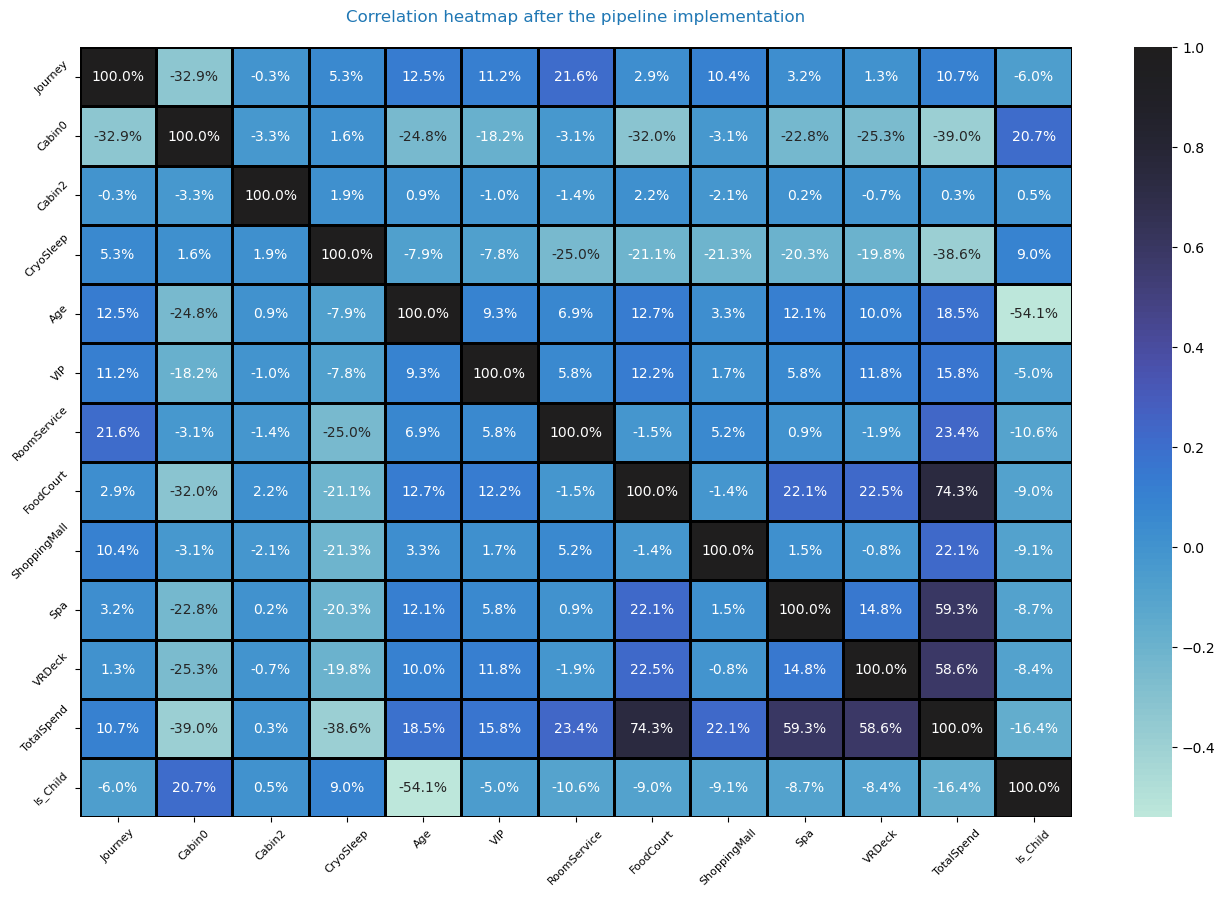

In [31]:
# Plotting correlation plot after the pipeline:-
fig, ax= plt.subplots(1,1, figsize= (16,10));
sns.heatmap(Xtrain.corr(), cmap = 'icefire', annot= True, fmt= '.1%', 
            linewidth= 1.0, linecolor= 'black', ax=ax, center= True);
ax.set_title("Correlation heatmap after the pipeline implementation\n", fontsize= 12, color= 'tab:blue');
plt.yticks(rotation= 45, fontsize= 8);
plt.xticks(rotation= 45, fontsize= 8);
plt.show();

collect();

# 3. Model Training and Development:-

In this section, we train ML models (tree based models) and develop the test set predictions using the pipeline output. We follow the below routine:-

1. Sample the train data using a higher fraction (say- 90%) with different random states. Develop the model train, development sets thereby
2. Use an ensemble approach on the sampled model train set and use the validation set for the scoring metric calculation
3. Make a test set prediction using the model trained and so fitted. Predicting probabilities seems to be a better option than predicting labels
4. Store the test set prediction in an output dataframe 
5. Once all models are executed, consider the probability prediction average across the n-model runs and use it as a final prediction
6. Consider calibrating the model if needed. This is a last decision after the model development. Mostly, calibration is not necessary

In [32]:
# Estimating the best model parameters using grid-search:-
param_grid = {'n_estimators': [500],
              'learning_rate': np.arange(0.05,0.15,0.01),
              'max_depth': range(4,10,1)};

mdl_grid = {'LGBM': LGBMClassifier(n_estimators= 500),
            'XgBoost': XGBClassifier(n_estimators=500),
            'CatBoost': CatBoostClassifier(n_estimators=500, verbose= False)
           };
mdl_best_params = {};

for mdl_name, mdl in tqdm(mdl_grid.items()):
    print(colored(f"\nCurrent model is {mdl_name}\n", color= 'blue', attrs= ['bold', 'dark']));
    grid= GridSearchCV(estimator= mdl, param_grid= param_grid, scoring= 'roc_auc', cv= 5);
    grid.fit(Xtrain, ytrain, verbose= False);
    print(colored(f"{grid.best_params_}\n", color= 'red'));
    mdl_best_params[mdl_name] = grid.best_params_;  
    collect();
collect();             

  0%|          | 0/3 [00:00<?, ?it/s]


Current model is LGBM

{'learning_rate': 0.060000000000000005, 'max_depth': 4, 'n_estimators': 500}


Current model is XgBoost

[09:56:27] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[09:56:29] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[09:56:32] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic'

In [33]:
# Creating the output dataframe for test predictions:-
Mdl_Pred_Prf = pd.DataFrame(data= None, index= xtest['PassengerId'], columns= None);

# Defining the training function for the ensemble models:-
def TrainEnsembles(mdl_name: str, n_mdl_runs: np.int16 = 500, mdl_best_params= mdl_best_params, 
                   sample_frac:np.float16 = 0.95):
    """
    This function trains the ensemble models based on the best parameters obtained from the grid-search.
    Inputs- 
    1. mdl_name- (string):- Model ensemble method
    2. n_mdl_runs- (int):- Number of candidates
    3. mdl_best_params- (dict):- Best parameters (from grid search)
    4. sample_frac- (float):- Sampling fraction for the training set
    """;
    
    for i in tqdm(range(0,n_mdl_runs,1)):
        print(colored(f"\nIteration{i}", color= 'blue', attrs= ['bold', 'dark']));
        xtr = Xtrain.sample(random_state = i, frac= sample_frac);
        xdev = Xtrain.loc[~Xtrain.index.isin(xtr.index)];
        ytr = ytrain[xtr.index];
        ydev = ytrain[xdev.index];
        
        if mdl_name == 'LGBM':
            mdl = LGBMClassifier(**mdl_best_params.get('LGBM'));
        elif mdl_name == 'XgBoost':
            mdl = XGBClassifier(**mdl_best_params.get('XgBoost'));
        elif mdl_name == 'CatBoost':
            mdl = CatBoostClassifier(**mdl_best_params.get('CatBoost'), eval_metric= 'AUC');
        
        if mdl_name != 'CatBoost':
            mdl.fit(xtr, ytr, eval_set=[(xtr, ytr), (xdev, ydev)], eval_metric= ['auc'], 
                    early_stopping_rounds= 35, verbose= 50);
        elif mdl_name == 'CatBoost':
            mdl.fit(xtr, ytr, eval_set=[(xtr, ytr), (xdev, ydev)], early_stopping_rounds= 35,verbose= 50);
            
        Mdl_Pred_Prf[f"{mdl_name}{i}"] = mdl.predict_proba(Xtest)[:,1];

        del xtr, xdev, ytr, ydev;
        collect();
    collect();
collect();

In [34]:
TrainEnsembles(mdl_name= 'LGBM', n_mdl_runs = 1000);
TrainEnsembles(mdl_name= 'XgBoost', n_mdl_runs = 1000);
TrainEnsembles(mdl_name= 'CatBoost', n_mdl_runs = 1000);

collect();

  0%|          | 0/1000 [00:00<?, ?it/s]


Iteration0
Training until validation scores don't improve for 35 rounds
[50]	training's auc: 0.897301	training's binary_logloss: 0.414307	valid_1's auc: 0.889102	valid_1's binary_logloss: 0.418963
[100]	training's auc: 0.904697	training's binary_logloss: 0.392201	valid_1's auc: 0.895801	valid_1's binary_logloss: 0.400601
[150]	training's auc: 0.912213	training's binary_logloss: 0.376691	valid_1's auc: 0.903347	valid_1's binary_logloss: 0.384707
[200]	training's auc: 0.918482	training's binary_logloss: 0.363673	valid_1's auc: 0.907258	valid_1's binary_logloss: 0.376631
[250]	training's auc: 0.923364	training's binary_logloss: 0.353629	valid_1's auc: 0.909749	valid_1's binary_logloss: 0.371473
[300]	training's auc: 0.927367	training's binary_logloss: 0.345219	valid_1's auc: 0.913554	valid_1's binary_logloss: 0.365858
[350]	training's auc: 0.932283	training's binary_logloss: 0.335657	valid_1's auc: 0.915653	valid_1's binary_logloss: 0.361048
Early stopping, best iteration is:
[345]	train

  0%|          | 0/1000 [00:00<?, ?it/s]


Iteration0
[0]	validation_0-auc:0.85712	validation_1-auc:0.86483
[50]	validation_0-auc:0.89410	validation_1-auc:0.88579
[100]	validation_0-auc:0.90279	validation_1-auc:0.89136
[150]	validation_0-auc:0.90795	validation_1-auc:0.89851
[200]	validation_0-auc:0.91343	validation_1-auc:0.90355
[250]	validation_0-auc:0.91738	validation_1-auc:0.90606
[300]	validation_0-auc:0.92067	validation_1-auc:0.90747
[350]	validation_0-auc:0.92321	validation_1-auc:0.90805
[400]	validation_0-auc:0.92688	validation_1-auc:0.91014
[450]	validation_0-auc:0.93012	validation_1-auc:0.91201
[499]	validation_0-auc:0.93314	validation_1-auc:0.91351

Iteration1
[0]	validation_0-auc:0.85991	validation_1-auc:0.82542
[50]	validation_0-auc:0.89599	validation_1-auc:0.85153
[100]	validation_0-auc:0.90530	validation_1-auc:0.85706
[150]	validation_0-auc:0.91117	validation_1-auc:0.85982
[162]	validation_0-auc:0.91244	validation_1-auc:0.85988

Iteration2
[0]	validation_0-auc:0.85635	validation_1-auc:0.87448
[50]	validation_0-au

  0%|          | 0/1000 [00:00<?, ?it/s]


Iteration0
0:	test: 0.8314478	test1: 0.8450630	best: 0.8450630 (0)	total: 14.2ms	remaining: 7.07s
50:	test: 0.8928465	test1: 0.8921016	best: 0.8921016 (50)	total: 608ms	remaining: 5.36s
100:	test: 0.9071661	test1: 0.9043753	best: 0.9043753 (100)	total: 1.41s	remaining: 5.58s
150:	test: 0.9157573	test1: 0.9076186	best: 0.9076822 (141)	total: 2s	remaining: 4.62s
200:	test: 0.9235798	test1: 0.9137025	best: 0.9143808 (195)	total: 2.57s	remaining: 3.82s
250:	test: 0.9313630	test1: 0.9180269	best: 0.9180269 (250)	total: 3.13s	remaining: 3.1s
300:	test: 0.9380963	test1: 0.9184932	best: 0.9194472 (277)	total: 3.62s	remaining: 2.39s
Stopped by overfitting detector  (35 iterations wait)

bestTest = 0.9194471531
bestIteration = 277

Shrink model to first 278 iterations.

Iteration1
0:	test: 0.8336543	test1: 0.8090834	best: 0.8090834 (0)	total: 10ms	remaining: 4.99s
50:	test: 0.8943466	test1: 0.8509597	best: 0.8509597 (50)	total: 692ms	remaining: 6.09s
100:	test: 0.9080791	test1: 0.8634106	best: 

In [36]:
# Preparing the submission file:-
Mdl_Pred_Prf['Transported'] = Mdl_Pred_Prf.median(axis=1);
Mdl_Pred_Prf['Transported'] = np.where(Mdl_Pred_Prf['Transported'] >=0.50, True,False)

Mdl_Pred_Prf.reset_index()[['PassengerId', 'Transported']].to_csv("submission_Nafis_2.csv", index= False);